In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# plt.style.use('tufte')

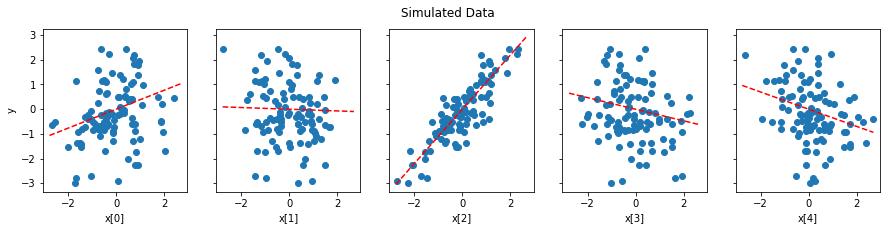

In [3]:
# Trailing underscore means the model has no access to the variable
np.random.seed(0)

ndims = 5
ndata = 100
X = np.random.randn(ndata, ndims)
w_ = np.random.randn(ndims)

noise_ = 0.1 * np.random.randn(ndata)
y_obs = X.dot(w_) + noise_


fig, axes = plt.subplots(sharey=True, ncols=ndims, figsize=(15, 3))

t = np.linspace(X.min(), X.max())
for idx, (ax, x) in enumerate(zip(axes.ravel(), X.T)):
    ax.plot(x, y_obs, 'o');
    ax.plot(t, w_[idx] * t, 'r--')
    ax.set_xlabel(f'x[{idx}]')
axes[0].set_ylabel('y')
fig.suptitle('Simulated Data');

## The Model

We have generated a linear regression dataset with 5 dimensions and 100 datapoints. 

In each library, we will define the joint probability distribution

$$
p(\mathbf{w}) \sim \mathcal{N}(\mathbf{0}, I_5)\\
p(\mathbf{y} | X, \mathbf{w}) \sim \mathcal{N}(X\mathbf{w}, 0.1I_{100}),
$$
where $I_5$ is a $5 \times 5$ identity matrix, and $I_{100}$ a $100 \times 100$ identity.

We then provide code to sample 1,000 draws from the posterior distribution: 

$$
p(\mathbf{w} | X, \mathbf{y}) \propto p(\mathbf{y} | X, \mathbf{w}) p(\mathbf{w})
$$

Note that in this case we can just do the math, and the actual posterior is

$$
p(\mathbf{w} | X, \mathbf{y}) = \mathcal{N}((X^TX + I_5)^{-1}X^Ty, (X^TX + I_5)^{-1})
$$



In [4]:
num_warmup = 1000
num_samples = 1000
num_chains = 4

## PyStan

In [5]:
# import nest_asyncio
# nest_asyncio.apply()

# import stan

In [6]:
import pystan

In [7]:
import pkg_resources
pkg_resources.get_distribution('pystan').version

'2.19.1.1'

In [8]:
linear_regression = """
data {
  int<lower=0> N;   // number of data items
  int<lower=0> K;   // number of predictors
  matrix[N, K] X;   // predictor matrix
  vector[N] y;      // outcome vector
}
parameters {
  vector[K] w;       // coefficients for predictors
}
model {
  y ~ normal(X * w, 0.1);  // likelihood
}
"""

linear_data = {'N': ndata,
               'K': ndims,
               'y': y_obs,
               'X': X
              }

In [9]:
# posterior = stan.build(linear_regression, data=linear_data, random_seed=1)

In [10]:
sm = pystan.StanModel(model_code=linear_regression)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_37b8e41c9d58148edcdc9d099a42ee4b NOW.
In file included from /var/folders/91/l3bk8qmn3c3fgr6y18_2szbm0000gn/T/pystan_xw0319bh/stanfit4anon_model_37b8e41c9d58148edcdc9d099a42ee4b_8588780215035782638.cpp:771:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecat

In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:86:63: warning: converting the enum constant to a boolean [-Wint-in-bool-context]
    MayLinearVectorize = bool(MightVectorize) && MayLinearize && DstHasDirectAccess
                                                              ^
/Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:607:20: note: in instantiation of template class 'Eigen::internal::copy_using_evaluator_traits<Eigen::internal::evaluator<Eigen::Matrix<double, -1, -1, 0, -1, -1> >, Eigen::internal::evaluator<Eigen::Product<Eigen::Matrix<double, -1, -1, 0, -1, -1>, Eigen::Transpose<const Eigen::Matrix<double,

In file included from /var/folders/91/l3bk8qmn3c3fgr6y18_2szbm0000gn/T/pystan_xw0319bh/stanfit4anon_model_37b8e41c9d58148edcdc9d099a42ee4b_8588780215035782638.cpp:780:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/en

In file included from /var/folders/91/l3bk8qmn3c3fgr6y18_2szbm0000gn/T/pystan_xw0319bh/stanfit4anon_model_37b8e41c9d58148edcdc9d099a42ee4b_8588780215035782638.cpp:781:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of

In file included from /var/folders/91/l3bk8qmn3c3fgr6y18_2szbm0000gn/T/pystan_xw0319bh/stanfit4anon_model_37b8e41c9d58148edcdc9d099a42ee4b_8588780215035782638.cpp:780:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/en

In file included from /var/folders/91/l3bk8qmn3c3fgr6y18_2szbm0000gn/T/pystan_xw0319bh/stanfit4anon_model_37b8e41c9d58148edcdc9d099a42ee4b_8588780215035782638.cpp:780:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/en

In file included from /var/folders/91/l3bk8qmn3c3fgr6y18_2szbm0000gn/T/pystan_xw0319bh/stanfit4anon_model_37b8e41c9d58148edcdc9d099a42ee4b_8588780215035782638.cpp:780:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/en

In file included from /var/folders/91/l3bk8qmn3c3fgr6y18_2szbm0000gn/T/pystan_xw0319bh/stanfit4anon_model_37b8e41c9d58148edcdc9d099a42ee4b_8588780215035782638.cpp:780:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/en

In file included from /var/folders/91/l3bk8qmn3c3fgr6y18_2szbm0000gn/T/pystan_xw0319bh/stanfit4anon_model_37b8e41c9d58148edcdc9d099a42ee4b_8588780215035782638.cpp:780:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/en

/Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:607:20: note: in instantiation of template class 'Eigen::internal::copy_using_evaluator_traits<Eigen::internal::evaluator<Eigen::Matrix<double, -1, 1, 0, -1, 1> >, Eigen::internal::evaluator<Eigen::CwiseBinaryOp<Eigen::internal::scalar_sum_op<double, double>, const Eigen::CwiseBinaryOp<Eigen::internal::scalar_product_op<double, double>, const Eigen::CwiseNullaryOp<Eigen::internal::scalar_constant_op<double>, const Eigen::Matrix<double, -1, 1, 0, -1, 1> >, const Eigen::Matrix<double, -1, 1, 0, -1, 1> >, const Eigen::CwiseBinaryOp<Eigen::internal::scalar_product_op<double, double>, const Eigen::CwiseNullaryOp<Eigen::internal::scalar_constant_op<double>, const Eigen::Matrix<double, -1, 1, 0, -1, 1> >, const Eigen::CwiseNullaryOp<Eigen::internal::scalar_constant_op<double>, Eigen::Matrix<double, -1, 1, 0, -1, 1> > > > >, Eigen::interna

In file included from /var/folders/91/l3bk8qmn3c3fgr6y18_2szbm0000gn/T/pystan_xw0319bh/stanfit4anon_model_37b8e41c9d58148edcdc9d099a42ee4b_8588780215035782638.cpp:780:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/en

In file included from /var/folders/91/l3bk8qmn3c3fgr6y18_2szbm0000gn/T/pystan_xw0319bh/stanfit4anon_model_37b8e41c9d58148edcdc9d099a42ee4b_8588780215035782638.cpp:780:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/en

In file included from /var/folders/91/l3bk8qmn3c3fgr6y18_2szbm0000gn/T/pystan_xw0319bh/stanfit4anon_model_37b8e41c9d58148edcdc9d099a42ee4b_8588780215035782638.cpp:780:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/zhishiw/.pyenv/versions/3.7.8/en

154 warnings generated.


In [39]:
# %%timeit
fit = sm.sampling(data=linear_data, iter=(num_warmup + num_samples), warmup=num_warmup, chains=num_chains, seed=1)


Gradient evaluation took 6.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 5.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.68 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%

In [48]:
# %%timeit
# fit = posterior.sample(num_chains=num_chains, num_warmup=num_warmup, num_samples=num_samples)

Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 9.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.97 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 9.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.97 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.

2.04 s ± 59.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Tensorflow Probability

In [12]:
import tensorflow as tf
import tensorflow_probability as tfp

In [13]:
print(tf.__version__)
print(tfp.__version__)

2.7.0
0.15.0


In [14]:
tfd = tfp.distributions

X_tensor = tf.convert_to_tensor(X, dtype='float32')

@tf.function
def target_log_prob_fn(w):
    w_dist = tfd.Normal(loc=tf.zeros((ndims, 1)), scale=1.0, name="w")
    w_prob = tf.reduce_sum(w_dist.log_prob(w))
    y_dist = tfd.Normal(loc=tf.matmul(X_tensor, w), scale=0.1, name="y")
    y_prob = tf.reduce_sum(y_dist.log_prob(y_obs.reshape(-1, 1)))
    return y_prob # w_prob + y_prob??

In [15]:
def run_chain():
    # Initialize the HMC transition kernel.
    adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
        tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=target_log_prob_fn,
            num_leapfrog_steps=4,
            step_size=0.01),
        num_adaptation_steps=int(num_warmup * 0.8))

    tfp_samples, is_accepted = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_warmup,
        current_state=tf.zeros((ndims, 1)),
        kernel=adaptive_hmc,
        seed=1,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
    
    return tfp_samples

In [16]:
# %%timeit
tf.random.set_seed(seed=1)

tfp_chains = [run_chain() for i in range(num_chains)]
tfp_samples = tf.concat(tfp_chains, 0)

In [17]:
# implement chains for tfp: https://juanitorduz.github.io/tfp_hcm/

In [18]:
#map
def loss(w):
#     w_dist = tfd.Normal(loc=tf.zeros((ndims, 1)), scale=1.0, name="w")
#     w_prob = tf.reduce_sum(w_dist.log_prob(w))
    y_dist = tfd.Normal(loc=tf.matmul(X_tensor, tf.reshape(w, (ndims, 1))), scale=0.1) # w doesnt work;
    y_prob = tf.reduce_sum(y_dist.log_prob(y_obs.reshape(-1, 1)))
    return -y_prob

@tf.function
def loss_and_gradient(w):
    return tfp.math.value_and_gradient(lambda w: loss(w), w)

def optimizing():
    init = tf.zeros(ndims) # (ndims, 1) doesn't work; why??
    opt = tfp.optimizer.lbfgs_minimize(
        lambda w: loss_and_gradient(w), init, max_iterations=1000
    )
    return opt

In [19]:
tf.random.set_seed(1)
mle = optimizing()

In [20]:
print(mle.num_iterations)
print(mle.converged)
mle.position

tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(True, shape=(), dtype=bool)


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.3725721 , -0.03540492,  1.0944514 , -0.23426947, -0.3391319 ],
      dtype=float32)>

## Pymc3

In [21]:
import pymc3 as pm
import theano.tensor as tt

In [22]:
print(pm.__version__)

3.11.4


In [23]:
# %%timeit
with pm.Model():
    w = pm.Normal('w', 0, 1, shape=ndims)
    y = pm.Normal('y', tt.dot(X, w), 0.1, observed=y_obs)
    pymc_samples = pm.sample(draws=num_samples, tune=num_warmup, chains=num_chains, random_seed=1)

/Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  """
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [w]


INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [24]:
# map
with pm.Model():
    w = pm.Normal('w', 0, 1, shape=ndims)
    y = pm.Normal('y', tt.dot(X, w), 0.1, observed=y_obs)
    pymc_map = pm.find_MAP()

In [25]:
pymc_map

{'w': array([ 0.37252623, -0.03542254,  1.09433494, -0.23424548, -0.33909735])}

## Pyro

In [26]:
import pyro
import torch
from pyro.infer.mcmc import NUTS, MCMC
import pyro.distributions as dist

In [27]:
print(pyro.__version__)

1.7.0


In [28]:
def model(X):
    w = pyro.sample('w', dist.Normal(torch.zeros(ndims), torch.ones(ndims)))
    y = pyro.sample('y', dist.Normal(torch.matmul(X, w), 0.1 * torch.ones(ndata)), obs=torch.as_tensor(y_obs, dtype=torch.float32))
    return y

In [29]:
%%time
nuts_kernel = NUTS(model, adapt_step_size=True)
pyro_mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=num_warmup, num_chains=num_chains)
pyro_mcmc.run(torch.as_tensor(X, dtype=torch.float32))

Warmup [1]:   0%|          | 0/2000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2000 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/2000 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/2000 [00:00, ?it/s]

CPU times: user 2.55 s, sys: 662 ms, total: 3.21 s
Wall time: 12.2 s


## numpyro



In [30]:
import jax
import jax.numpy as jnp
from jax import random
from jax.config import config; config.update("jax_platform_name", "cpu")

import numpyro
import numpyro.distributions as dist
from numpyro import sample
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

/Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [31]:
print(jax.__version__)
print(numpyro.__version__)

0.2.25
0.8.0


In [32]:
def model(X):
    w = sample('w', dist.Normal(jnp.zeros(ndims), jnp.ones(ndims)))
    y = sample('y', dist.Normal(jnp.matmul(X, w), 0.1 * jnp.ones(ndata)), obs=y_obs)

In [33]:
# %%timeit
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
mcmc.run(
    rng_key_, X=X
)
mcmc.print_summary()
npyro_samples = mcmc.get_samples()

INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
/Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/numpyro/infer/mcmc.py:280: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 6412.93it/s, 7 steps of size 6.2


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      w[0]      0.37      0.01      0.37      0.36      0.39   5075.55      1.00
      w[1]     -0.04      0.01     -0.04     -0.05     -0.02   4453.21      1.00
      w[2]      1.09      0.01      1.09      1.08      1.11   4906.69      1.00
      w[3]     -0.23      0.01     -0.23     -0.25     -0.22   4947.59      1.00
      w[4]     -0.34      0.01     -0.34     -0.36     -0.32   3957.17      1.00

Number of divergences: 0


## Check Accuracy

In [34]:
true = np.linalg.inv(X.T.dot(X) + np.eye(5)).dot(X.T.dot(y_obs))

In [40]:
outputs = {
    'pystan': fit.extract()['w'].mean(axis=0), #fit['w'].mean(axis=1),
    'pymc3': pymc_samples['w'].mean(axis=0), 
    'pyro': pyro_mcmc.get_samples()['w'].numpy().mean(axis=0),
    'numpyro': npyro_samples['w'].mean(axis=0),
    'tfp': tf.reduce_mean(tfp_samples, axis=0).numpy().flatten(),
}

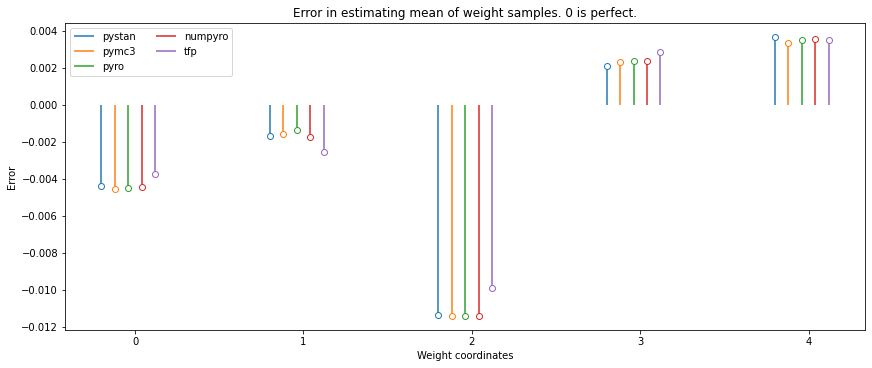

In [41]:
fig, ax = plt.subplots(figsize=(12, 5), constrained_layout=True)
bg = ax.get_facecolor()

offset = 0.4

for idx, (name, value) in enumerate(outputs.items()):
    x = np.arange(5) + (idx * offset / 5 - offset / 2)
    y = true - value.flatten()
    ax.vlines(x, 0, y, label=name, color=f'C{idx}')
    ax.plot(x, y, 'o', color=f'C{idx}', mfc=bg)

ax.set_title('Error in estimating mean of weight samples. 0 is perfect.')
ax.set_ylabel('Error')
ax.set_xlabel('Weight coordinates')
ax.legend(ncol=2);